In [1]:
# Cell 1: Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel
from qtorch_plus.quant import posit_quantize

# Load model
model_id = 'gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_id)
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Posit config
nsize = 4
es = 0
epsilon = 1e-8


/home/yimin/miniconda3/envs/posit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-29 21:29:15.687924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 21:29:15.703136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-29 21:29:15.717123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-29 21:29:

ninja: no work to do.


Loading extension module quant_cpu...
Using /home/yimin/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/yimin/.cache/torch_extensions/py312_cu121/quant_cuda/build.ninja...
/home/yimin/miniconda3/envs/posit/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module quant_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module quant_cuda...


ninja: no work to do.


In [2]:
# Cell 2: Pick a few layers to analyze
layer_ids = [0, 1]  # you can change this
component_names = ["attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj"]

layers_to_analyze = []
for lid in layer_ids:
    block = model.transformer.h[lid]
    for name in component_names:
        submodule = eval(f"block.{name}")
        layers_to_analyze.append((f"layer{lid}.{name}", submodule))



Analyzing layer0.attn.c_attn
Best log2(scale) = 3, SQNR = 15.65 dB


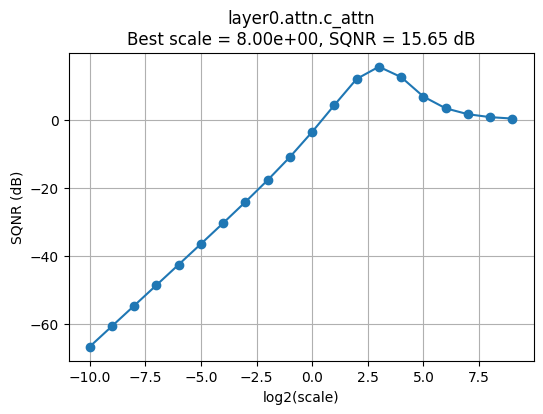


Analyzing layer0.attn.c_proj
Best log2(scale) = 4, SQNR = 14.80 dB


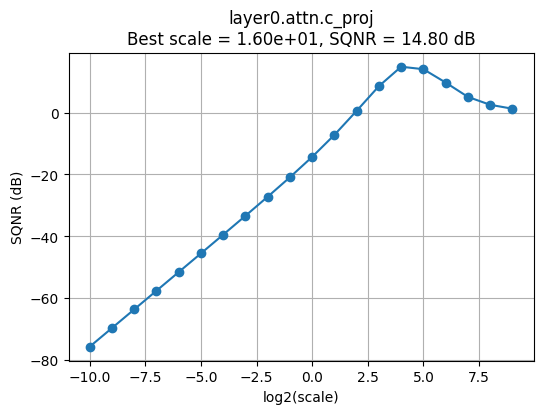


Analyzing layer0.mlp.c_fc
Best log2(scale) = 3, SQNR = 16.30 dB


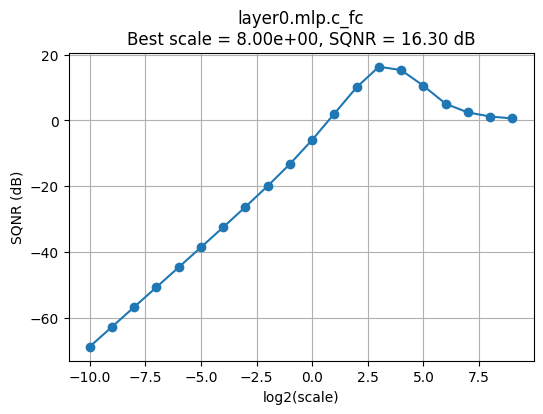


Analyzing layer0.mlp.c_proj
Best log2(scale) = 6, SQNR = 14.05 dB


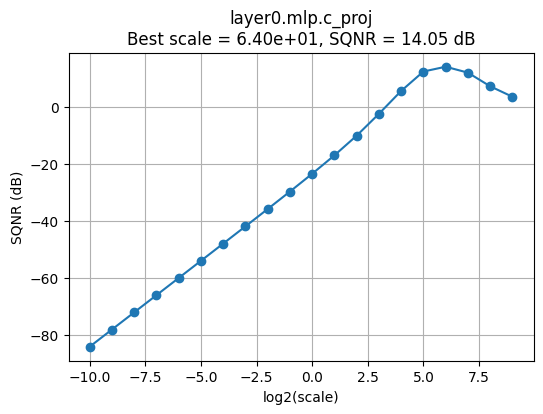


Analyzing layer1.attn.c_attn
Best log2(scale) = 3, SQNR = 15.47 dB


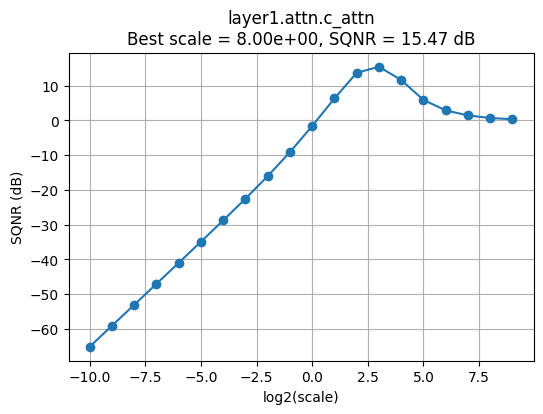


Analyzing layer1.attn.c_proj
Best log2(scale) = 5, SQNR = 10.56 dB


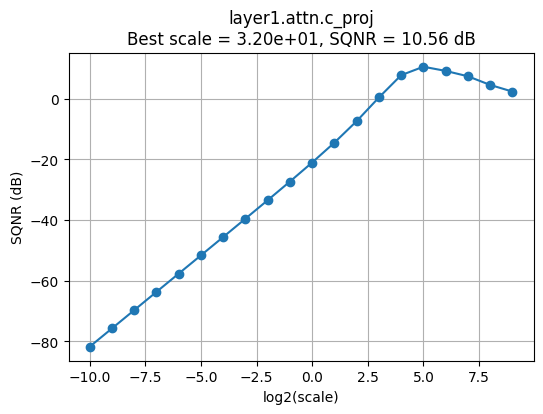


Analyzing layer1.mlp.c_fc
Best log2(scale) = 4, SQNR = 16.36 dB


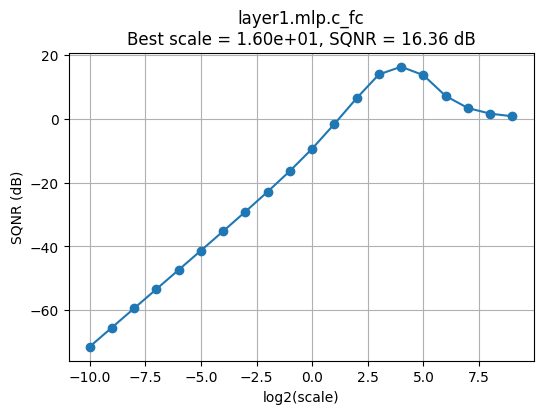


Analyzing layer1.mlp.c_proj
Best log2(scale) = 6, SQNR = 13.35 dB


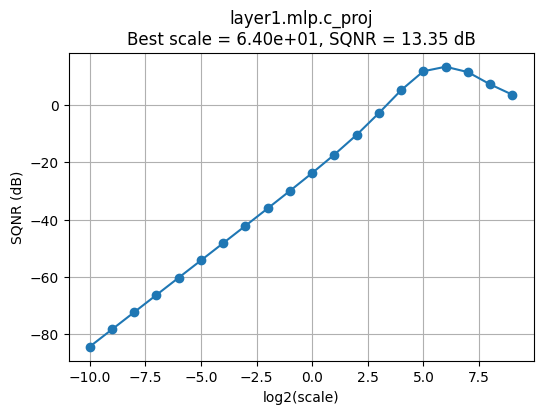

In [6]:
# Cell 3: SQNR sweep and plotting
for label, module in layers_to_analyze:
    print(f"\nAnalyzing {label}")
    with torch.no_grad():
        weights = module.weight.data.detach().float().cpu()
        signal_power = torch.sum(weights ** 2)

        max_val = weights.abs().max()
        norm_weights = weights / (max_val + epsilon)

        sweep_exponents = np.arange(-10, 10)  # 2^-6 to 2^3
        sweep_scales = [2.0 ** e for e in sweep_exponents]
        sqnrs = []

        for scale in sweep_scales:
            quantized = posit_quantize(norm_weights, nsize=nsize, es=es, scale=scale)
            quantized_rescaled = quantized * max_val
            noise = ((weights - quantized_rescaled) ** 2).sum() + epsilon
            sqnr = 10 * torch.log10(signal_power / noise)
            sqnrs.append(sqnr.item())

        best_idx = int(np.argmax(sqnrs))
        best_scale = sweep_scales[best_idx]
        best_sqnr = sqnrs[best_idx]

        print(f"Best log2(scale) = {sweep_exponents[best_idx]}, SQNR = {best_sqnr:.2f} dB")


        # Plot
        plt.figure(figsize=(6, 4))
        plt.plot(sweep_exponents, sqnrs, marker='o')
        plt.title(f"{label}\nBest scale = {best_scale:.2e}, SQNR = {best_sqnr:.2f} dB")
        plt.xlabel("log2(scale)")
        plt.ylabel("SQNR (dB)")
        plt.grid(True)
        plt.show()
